In this notebook, we
- prepare for features from raw data
- perform exploratory data analysis (e.g. analyzing correlations), and
- generate new features

Data roughly falls into (i) personal information (ii) loan information and (iii) days past due (dpd) structures.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

file_path = 'home-credit-credit-risk-model-stability/csv_files/train' #change the path if needed

# Loading data

First, we load basic information from the base table.

In [3]:
data = pd.read_csv(file_path+'/train_'+'base.csv')
data.head()

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [4]:
# Get the following static info:
# 'annuity_780A','mainoccupationinc_384A','numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L','pmtnum_254L','totaldebt_9A','totalsettled_863A'
# These include annuity amount, income, instalment info (paid, with/without days past due (dpd), total debts and total settled instalments

person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')
df = person_1.filter(['case_id','mainoccupationinc_384A'])
df = df.groupby('case_id').agg('max')
data['main income'] = df['mainoccupationinc_384A'].values
del person_1, df

static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
df = static[['case_id','maininc_215A','annuity_780A','numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L','pmtnum_254L','totaldebt_9A','totalsettled_863A']]
del static
static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
df2 = static2[['case_id','maininc_215A','annuity_780A','numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L','pmtnum_254L','totaldebt_9A','totalsettled_863A']]
del static2
df = pd.concat([df, df2])
del df2
for i in df.columns:
    if i != 'case_id':
        data[i] = df[i].values

del df

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/2589186404.py:5: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/2589186404.py:11: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/2589186404.py:14: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')


In [5]:
# So far we've got the following features.
# Note that there are null values for the latter columns; we will deal with them later.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 16 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   case_id                     1526659 non-null  int64  
 1   date_decision               1526659 non-null  object 
 2   MONTH                       1526659 non-null  int64  
 3   WEEK_NUM                    1526659 non-null  int64  
 4   target                      1526659 non-null  int64  
 5   main income                 1526659 non-null  float64
 6   maininc_215A                1015404 non-null  float64
 7   annuity_780A                1526659 non-null  float64
 8   numinstlsallpaid_934L       1080990 non-null  float64
 9   numinstlswithdpd10_728L     1070164 non-null  float64
 10  numinstlswithoutdpd_562L    1070164 non-null  float64
 11  numinstpaid_4499208L        679468 non-null   float64
 12  numinsttopaygrest_4493213L  686013 non-null   float64
 1

Next, we get information from credit bureau (cb). As a large population of the observation does not have information in the external source, we select `numberofqueries_373L` and `riskassesment_302T` as features summarizing information from the external.

Remark: due to time constraint, we do not incorporate information from tax registries.

In [6]:
# Get 'numberofqueries_373L' and 'riskassesment_302T' from static info of cb data
static_cb = pd.read_csv(file_path+'/train_static_cb_0.csv')
data = data.merge(static_cb.filter(['case_id','numberofqueries_373L','riskassesment_302T']), on='case_id', how='left')
del static_cb

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/1435931482.py:2: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  static_cb = pd.read_csv(file_path+'/train_static_cb_0.csv')


In [7]:
# Take a look at these two features
# Note that only the population with risk assesment from cb is small
data.filter(['case_id','numberofqueries_373L','riskassesment_302T'])[pd.notna(data['riskassesment_302T'])]

,case_id,numberofqueries_373L,riskassesment_302T
484,484,1.0,59% - 66%
545,545,4.0,6% - 8%
579,579,4.0,1% - 1%
594,594,2.0,2% - 3%
596,596,5.0,67% - 100%
...,...,...,...
1525241,2701996,8.0,4% - 6%
1525906,2702661,1.0,2% - 3%
1526569,2703357,3.0,50% - 58%
1526587,2703377,0.0,1% - 1%


Finally, we gather the dpd info. They consist of dpd data for the current applications as well as previous applications of the clients, if any. We try to gather feature that reflects long term and short term behavior.

In [8]:
# Get the following features:
# 'avgdbddpdlast24m_3658932P','avgdbddpdlast3m_4187120P','maxdbddpdlast1m_3658939P'
# 'maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P'
# 'posfpd30lastmonth_3976960P','posfstqpd30lastmonth_3976962P'

static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
df = static[['case_id','avgdbddpdlast24m_3658932P','avgdbddpdlast3m_4187120P','maxdbddpdlast1m_3658939P','maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P','posfpd30lastmonth_3976960P','posfstqpd30lastmonth_3976962P']]
del static
static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
df2 = static2[['case_id','avgdbddpdlast24m_3658932P','avgdbddpdlast3m_4187120P','maxdbddpdlast1m_3658939P','maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P','posfpd30lastmonth_3976960P','posfstqpd30lastmonth_3976962P']]
del static2
df = pd.concat([df, df2])
del df2
for i in df.columns:
    if i != 'case_id':
        data[i] = df[i].values

del df

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/3553929787.py:6: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/3553929787.py:9: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')


In [9]:
# Get max dpd from previous applications. For convenience, we directly impute and aggregate here.
prev_apply = pd.read_csv(file_path+'/train_'+'applprev_1_1.csv')

#fill NA with 0
df = prev_apply.filter(['case_id','actualdpd_943P'])
df['actualdpd_943P']=df['actualdpd_943P'].fillna(0)

#group by max and join
df1 = pd.DataFrame({'case_id1': prev_apply.filter(['case_id','actualdpd_943P']).groupby('case_id').max().index.values,
                    'prevdpd_max': prev_apply.filter(['case_id','actualdpd_943P']).groupby('case_id').max()['actualdpd_943P']})
df2 = pd.DataFrame({'case_id1': data['case_id']})
df3 = pd.merge(df2, df1, on='case_id1', how='outer')
df3['prevdpd_max']=df3['prevdpd_max'].fillna(0)

data['prevdpd_max']=df3['prevdpd_max']
del df, df1, df2, df3, prev_apply

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/989761962.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  prev_apply = pd.read_csv(file_path+'/train_'+'applprev_1_1.csv')


Let us also incorporate family data and main source of income.

In [10]:
# Get number of children ('childnum_185L') and family status ('familystate_447L')
person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')

df = person_1.filter(['case_id','childnum_185L','familystate_447L','num_group1'])
data['familystate_447L'] = df[df['num_group1']==0]['familystate_447L'].values

df['childnum_185L']=df['childnum_185L'].fillna(0)
df2 = pd.DataFrame({'case_id': data['case_id'],
                    'childnum_185L': df.filter(['case_id','childnum_185L']).groupby('case_id').sum()['childnum_185L'].values})
data['childnum_185L']=df2['childnum_185L']
del df, df2

# Get type of income ('incometype_1044T')
df = person_1.filter(['case_id','incometype_1044T','num_group1'])
data['income type'] = df[df['num_group1']==0]['incometype_1044T'].values

del df, person_1

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/2998506112.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person_1 = pd.read_csv(file_path+'/train_'+'person_1.csv')


Now, we have the following table:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   case_id                        1526659 non-null  int64  
 1   date_decision                  1526659 non-null  object 
 2   MONTH                          1526659 non-null  int64  
 3   WEEK_NUM                       1526659 non-null  int64  
 4   target                         1526659 non-null  int64  
 5   main income                    1526659 non-null  float64
 6   maininc_215A                   1015404 non-null  float64
 7   annuity_780A                   1526659 non-null  float64
 8   numinstlsallpaid_934L          1080990 non-null  float64
 9   numinstlswithdpd10_728L        1070164 non-null  float64
 10  numinstlswithoutdpd_562L       1070164 non-null  float64
 11  numinstpaid_4499208L           679468 non-null   float64
 12  numinsttopaygr

# Exploratory data anlaysis

Just to get a feeling quickly of the correlations among features and target, we generate the following heat map.

As we haven't processed `riskassesment_302T`; this will be dealt with in a moment.

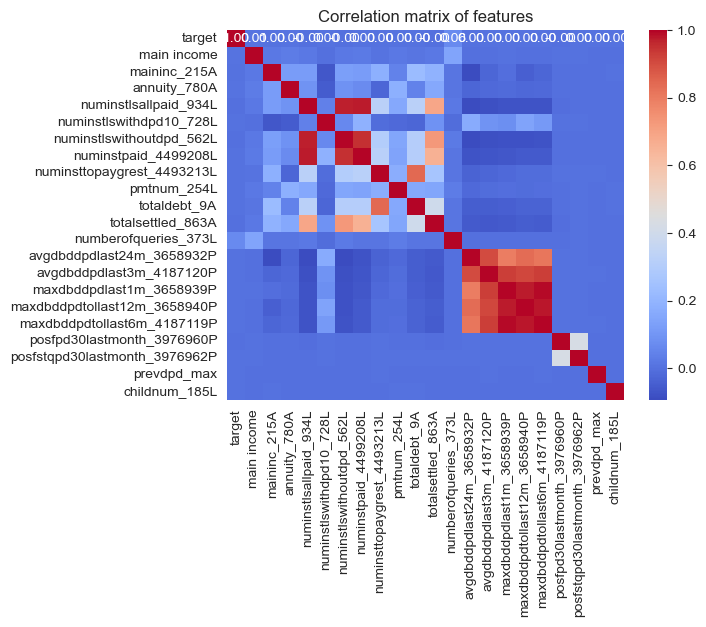

In [12]:
sns.heatmap(data.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','riskassesment_302T','familystate_447L','income type']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix of features')
plt.show()

The correlation matrix is as follow:

In [13]:
data.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','riskassesment_302T','familystate_447L','income type']).corr()

,target,main income,maininc_215A,annuity_780A,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithoutdpd_562L,numinstpaid_4499208L,numinsttopaygrest_4493213L,pmtnum_254L,...,numberofqueries_373L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,prevdpd_max,childnum_185L
target,1.000000,0.006057,0.002074,0.004754,-0.000665,0.001069,-0.000473,0.000556,0.002607,0.004469,...,0.064446,0.000937,0.000936,0.001609,0.001393,0.001302,-0.000250,0.000351,0.001641,0.001471
main income,0.006057,1.000000,0.019769,0.030121,0.020362,-0.002883,0.020824,0.021827,0.006599,0.020192,...,0.143461,-0.001527,-0.000055,0.001228,-0.000005,0.000169,0.001158,0.000533,-0.003140,0.000275
maininc_215A,0.002074,0.019769,1.000000,0.119117,0.117893,-0.064673,0.126863,0.116859,0.180001,0.045654,...,0.012851,-0.093665,-0.028031,-0.007803,-0.044171,-0.029388,-0.001677,-0.000283,-0.000012,0.001547
annuity_780A,0.004754,0.030121,0.119117,1.000000,0.090527,-0.052170,0.087820,0.069598,-0.028137,0.183698,...,0.012483,-0.027711,-0.017492,-0.014419,-0.022923,-0.018823,-0.003601,-0.002631,-0.001985,0.000262
numinstlsallpaid_934L,-0.000665,0.020362,0.117893,0.090527,1.000000,0.040282,0.973183,0.974878,0.320857,0.158218,...,0.021653,-0.090732,-0.081604,-0.075729,-0.075994,-0.074480,-0.004173,-0.000899,-0.002850,-0.000673
numinstlswithdpd10_728L,0.001069,-0.002883,-0.064673,-0.052170,0.040282,1.000000,0.062027,0.187971,-0.012149,-0.017101,...,-0.010714,0.163307,0.090121,0.077654,0.140120,0.110648,0.001479,0.003480,-0.000931,-0.000759
numinstlswithoutdpd_562L,-0.000473,0.020824,0.126863,0.087820,0.973183,0.062027,1.000000,0.952093,0.300776,0.149817,...,0.022613,-0.092333,-0.083323,-0.077204,-0.077191,-0.075865,-0.003499,-0.000118,-0.002923,-0.000803
numinstpaid_4499208L,0.000556,0.021827,0.116859,0.069598,0.974878,0.187971,0.952093,1.000000,0.317735,0.137431,...,0.009873,-0.073665,-0.069846,-0.063782,-0.058840,-0.058970,-0.002892,0.000217,-0.001472,-0.003204
numinsttopaygrest_4493213L,0.002607,0.006599,0.180001,-0.028137,0.320857,-0.012149,0.300776,0.317735,1.000000,0.173875,...,0.011839,-0.037797,-0.029272,-0.019739,-0.012141,-0.011777,0.001552,0.003528,0.001412,-0.000002
pmtnum_254L,0.004469,0.020192,0.045654,0.183698,0.158218,-0.017101,0.149817,0.137431,0.173875,1.000000,...,0.029403,-0.017456,-0.009234,-0.006525,-0.009975,-0.006768,-0.000128,0.003743,-0.001942,0.001020


From the above, we see that in general the features weakly correlate with the target (dafault=1, non-default=0).

- The instalment features are correlated with each other, as expected.
- The same goes for dpd features.

Next, we look at risk assessment from external source. It assigns a range of probability of default to applicants with information from cb. At this point, it is stored as a string. We shall convert it into float by looking at the average probability. This is done below.

In [14]:
# We count the ratio with observation for 'riskassesment_302T'. It is quite low.
data['riskassesment_302T'].count()/len(data['riskassesment_302T'])

0.03508249058892654

In [15]:
# Define function that extracts percentage
def get_prob(s):
    if pd.isna(s):
        return np.nan
    else:
        perc_1st = s.find('%')
        hyphen_blank = s.find(' - ')
        prob_1st = int(s[0: perc_1st])
        prob_2nd = int(s[hyphen_blank+3: len(s)-1])

        return 0.5*(prob_1st+prob_2nd)

In [16]:
# Get the mean probability of default assesment from cb
data['cb_risk_mean'] = data['riskassesment_302T'].apply(get_prob)

In [17]:
# Calculate the correlation of the mean probability with target. It is by far the highest.
data.filter(['target','cb_risk_mean']).corr()

,target,cb_risk_mean
target,1.000000,0.227546
cb_risk_mean,0.227546,1.000000


In [18]:
# Create an indicator for applicants with cb risk assessment info.
data['with_cb_risk'] = data['cb_risk_mean'].notnull().astype(int)

We shall impute `cb_risk_mean` by putting zero. Before that, we check that there is no obviously better candidate by looking at correlation with target.

In [19]:
j = -1
k = -1
for i in np.arange(0,1,0.01):
    test = data['cb_risk_mean'].fillna(i)
    if data['target'].corr(test) > j:
        k = data['target'].corr(test)
        j = i
    if i == 0:
        print('Filling null entries with 0 yields correlation ',k,' with the target.')
print('Filling null entries with ',j,' yields the highest correlation, which is ', k,'.')

Filling null entries with 0 yields correlation  0.06841137134896172  with the target.
Filling null entries with  0.07  yields the highest correlation, which is  0.0684218133716185 .


In [20]:
# Imputing 'cb_risk_mean' by filling with 0's
data['cb_risk_mean'] = data['cb_risk_mean'].fillna(0)

We examine again the correlations, with risk assesments from cb included.

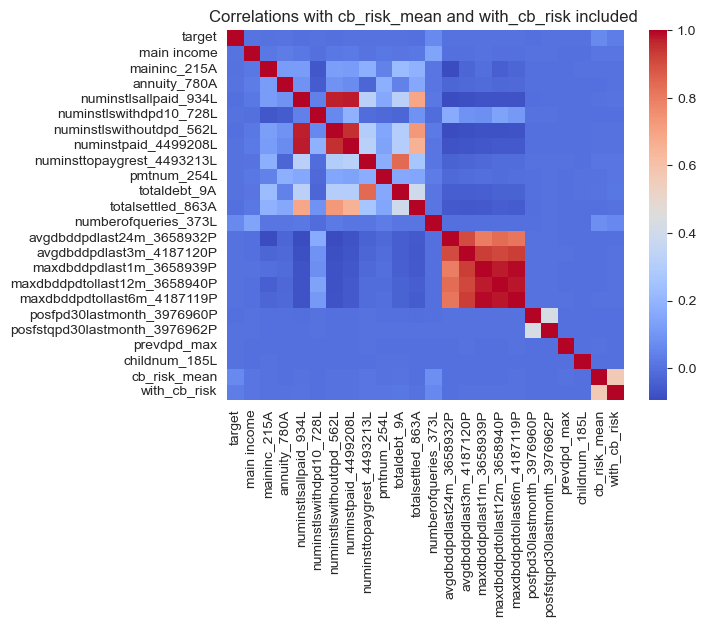

In [21]:
sns.heatmap(data.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','riskassesment_302T','familystate_447L','income type']).corr(), annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlations with cb_risk_mean and with_cb_risk included ')
plt.show()

In [107]:
data.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','riskassesment_302T','familystate_447L','income type']).corr()

,target,main income,annuity_780A,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithoutdpd_562L,numinstpaid_4499208L,numinsttopaygrest_4493213L,pmtnum_254L,totaldebt_9A,...,avgdbddpdlast3m_4187120P,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,prevdpd_max,childnum_185L,cb_risk_mean,with_cb_risk
target,1.000000,0.006057,0.004754,-0.000665,0.001069,-0.000473,0.000556,0.002607,0.004469,0.000863,...,0.000936,0.001609,0.001393,0.001302,-0.000250,0.000351,0.001641,0.001471,0.068411,0.034485
main income,0.006057,1.000000,0.030121,0.020362,-0.002883,0.020824,0.021827,0.006599,0.020192,0.010394,...,-0.000055,0.001228,-0.000005,0.000169,0.001158,0.000533,-0.003140,0.000275,0.011448,0.010634
annuity_780A,0.004754,0.030121,1.000000,0.090527,-0.052170,0.087820,0.069598,-0.028137,0.183698,0.046566,...,-0.017492,-0.014419,-0.022923,-0.018823,-0.003601,-0.002631,-0.001985,0.000262,-0.002045,0.002270
numinstlsallpaid_934L,-0.000665,0.020362,0.090527,1.000000,0.040282,0.973183,0.974878,0.320857,0.158218,0.321268,...,-0.081604,-0.075729,-0.075994,-0.074480,-0.004173,-0.000899,-0.002850,-0.000673,0.001701,0.004652
numinstlswithdpd10_728L,0.001069,-0.002883,-0.052170,0.040282,1.000000,0.062027,0.187971,-0.012149,-0.017101,-0.029459,...,0.090121,0.077654,0.140120,0.110648,0.001479,0.003480,-0.000931,-0.000759,-0.001091,-0.002283
numinstlswithoutdpd_562L,-0.000473,0.020824,0.087820,0.973183,0.062027,1.000000,0.952093,0.300776,0.149817,0.306842,...,-0.083323,-0.077204,-0.077191,-0.075865,-0.003499,-0.000118,-0.002923,-0.000803,0.001304,0.004154
numinstpaid_4499208L,0.000556,0.021827,0.069598,0.974878,0.187971,0.952093,1.000000,0.317735,0.137431,0.306911,...,-0.069846,-0.063782,-0.058840,-0.058970,-0.002892,0.000217,-0.001472,-0.003204,0.000820,0.001302
numinsttopaygrest_4493213L,0.002607,0.006599,-0.028137,0.320857,-0.012149,0.300776,0.317735,1.000000,0.173875,0.842939,...,-0.029272,-0.019739,-0.012141,-0.011777,0.001552,0.003528,0.001412,-0.000002,0.010076,0.013006
pmtnum_254L,0.004469,0.020192,0.183698,0.158218,-0.017101,0.149817,0.137431,0.173875,1.000000,0.154708,...,-0.009234,-0.006525,-0.009975,-0.006768,-0.000128,0.003743,-0.001942,0.001020,0.004331,0.010968
totaldebt_9A,0.000863,0.010394,0.046566,0.321268,-0.029459,0.306842,0.306911,0.842939,0.154708,1.000000,...,-0.048119,-0.044716,-0.036156,-0.036370,-0.000637,0.001197,-0.001491,0.000673,0.004926,0.013328


Now, we analyze the relationship between default and main source of income and annuity amount.

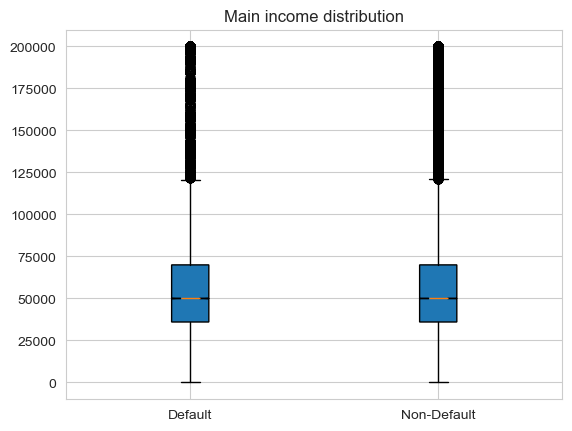

None

In [121]:
box_plot_data=[data[data['target']==1]['main income'].values,data[data['target']==0]['main income'].values]
plt.title("Main income distribution")
plt.boxplot(box_plot_data,notch='True',patch_artist=True,labels=['Default','Non-Default'])
display(plt.show())

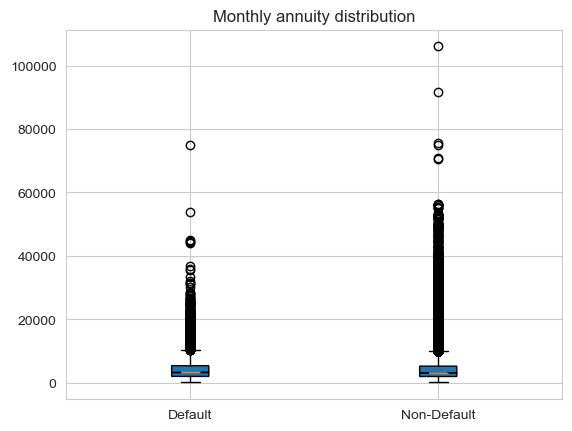

None

In [123]:
box_plot_data=[data[data['target']==1]['annuity_780A'].values,data[data['target']==0]['annuity_780A'].values]
plt.title("Monthly annuity distribution")
plt.boxplot(box_plot_data,notch='True',patch_artist=True,labels=['Default','Non-Default'])
display(plt.show())

In [118]:
print('Summary statistics of main income and monthly annuity for the dafault population:')
display(data[data['target']==1].filter(['main income','annuity_780A']).describe().drop(['count']))
print('Summary statistics of main income and monthly annuity for the non-dafault population:')
display(data[data['target']==0].filter(['main income','annuity_780A']).describe().drop(['count']))

Summary statistics of main income and monthly annuity for the dafault population:


,main income,annuity_780A
mean,58828.635914,4118.552493
std,34328.801709,3057.399452
min,0.000000,154.200000
25%,36000.000000,1991.600000
50%,50000.000000,3232.200000
75%,70000.000000,5375.900000
max,200000.000000,75020.400000


Summary statistics of main income and monthly annuity for the non-dafault population:


,main income,annuity_780A
mean,57671.093481,4036.631912
std,33315.374409,3004.910607
min,0.000000,80.800000
25%,36000.000000,1966.800000
50%,50000.000000,3150.000000
75%,70000.000000,5226.800300
max,200000.000000,106007.000000


The distributions of income and annuity for default and non-default population are similar. This explains the low correlations.

We stratify the data according to source of income (`income type`):

In [143]:
# Obtain stratified correlations according to income type
print('---Correlation between default and main income---')
print('overall population:',data.filter(['target','main income']).corr()['main income']['target'])
print()
for i in data['income type'].value_counts().index.values:
    print(i,': ',data[data['income type'] == i].filter(['target','main income']).corr()['main income']['target'])

---Correlation between default and main income---
overall population: 0.006056889536785905

PRIVATE_SECTOR_EMPLOYEE :  -0.0011781003906113881
SALARIED_GOVT :  0.017753211439991957
RETIRED_PENSIONER :  0.0026054083105037846
EMPLOYED :  -0.005396400478841165
SELFEMPLOYED :  -0.012469451288811217
OTHER :  -0.002355312828050268
HANDICAPPED_2 :  -0.011445167939770004
HANDICAPPED_3 :  -0.023181549122409523
HANDICAPPED :  nan


It turns out when the income type is `SALARIED_GOVT`, `SELFEMPLOYED`, `HANDICAPPED_2`or `HANDICAPPED_3`, the correlation between default and main income is more significant. 

In [146]:
print('Proportion of observations with income type PRIVATE_SECTOR_EMPLOYEE:',len(data[data['income type']=='PRIVATE_SECTOR_EMPLOYEE'])/len(data))
print('Proportion of observations with income type SALARIED_GOVT:',len(data[data['income type']=='SALARIED_GOVT'])/len(data))
print('Proportion of observations with income type SELFEMPLOYED:',len(data[data['income type']=='SELFEMPLOYED'])/len(data))
print('Proportion of observations with income type HANDICAPPED_2:',len(data[data['income type']=='HANDICAPPED_2'])/len(data))
print('Proportion of observations with income type HANDICAPPED_3:',len(data[data['income type']=='HANDICAPPED_3'])/len(data))

Proportion of observations with income type PRIVATE_SECTOR_EMPLOYEE: 0.32133043462882016
Proportion of observations with income type SALARIED_GOVT: 0.2447475172910257
Proportion of observations with income type SELFEMPLOYED: 0.019126078580743965
Proportion of observations with income type HANDICAPPED_2: 0.004828190185234555
Proportion of observations with income type HANDICAPPED_3: 0.0034441220993031187


In [145]:
print('---Correlation between default and monthly annuity---')
print('overall population:',data.filter(['target','annuity_780A']).corr()['annuity_780A']['target'])
print()
for i in data['income type'].value_counts().index.values:
    print(i,': ',data[data['income type'] == i].filter(['target','annuity_780A']).corr()['annuity_780A']['target'])

---Correlation between default and monthly annuity---
overall population: 0.004754476875556857

PRIVATE_SECTOR_EMPLOYEE :  0.006809061765187868
SALARIED_GOVT :  0.006816551584946582
RETIRED_PENSIONER :  0.002821123781036825
EMPLOYED :  0.005299322138634823
SELFEMPLOYED :  0.01026900338376141
OTHER :  0.007018947568531238
HANDICAPPED_2 :  0.020457509602056292
HANDICAPPED_3 :  0.0019652999851247563
HANDICAPPED :  nan


In [147]:
print('---Correlation between default and debts---')
print('overall population:',data.filter(['target','totaldebt_9A']).corr()['totaldebt_9A']['target'])
print()
for i in data['income type'].value_counts().index.values:
    print(i,': ',data[data['income type'] == i].filter(['target','totaldebt_9A']).corr()['totaldebt_9A']['target'])

---Correlation between default and debts---
overall population: 0.0008627652805294009

PRIVATE_SECTOR_EMPLOYEE :  0.001400053348045247
SALARIED_GOVT :  0.003557895615653431
RETIRED_PENSIONER :  0.0032095887125844274
EMPLOYED :  0.00012140436687657115
SELFEMPLOYED :  0.005516794855064897
OTHER :  -0.00644879528508953
HANDICAPPED_2 :  -0.00908580161713402
HANDICAPPED_3 :  -0.004558804657208889
HANDICAPPED :  nan


In [148]:
print('---Correlation between default and settled instalments---')
print('overall population:',data.filter(['target','totalsettled_863A']).corr()['totalsettled_863A']['target'])
print()
for i in data['income type'].value_counts().index.values:
    print(i,': ',data[data['income type'] == i].filter(['target','totalsettled_863A']).corr()['totalsettled_863A']['target'])

---Correlation between default and settled instalments---
overall population: -0.0017805906439092574

PRIVATE_SECTOR_EMPLOYEE :  0.0003117602481222176
SALARIED_GOVT :  0.002301186505948383
RETIRED_PENSIONER :  -0.0008704826356586845
EMPLOYED :  -0.0022570498557008666
SELFEMPLOYED :  0.001798823561229481
OTHER :  0.01905958933162236
HANDICAPPED_2 :  0.0011803832851589365
HANDICAPPED_3 :  0.010981565119353337
HANDICAPPED :  nan


In [149]:
print('---Correlation between default and number of instalments without dpd---')
print('overall population:',data.filter(['target','numinstlswithoutdpd_562L']).corr()['numinstlswithoutdpd_562L']['target'])
print()
for i in data['income type'].value_counts().index.values:
    print(i,': ',data[data['income type'] == i].filter(['target','numinstlswithoutdpd_562L']).corr()['numinstlswithoutdpd_562L']['target'])

---Correlation between default and number of instalments without dpd---
overall population: -0.0004726291669945198

PRIVATE_SECTOR_EMPLOYEE :  0.0007389952157562586
SALARIED_GOVT :  0.002123801025242651
RETIRED_PENSIONER :  0.00034935741185149476
EMPLOYED :  0.0016597887295693736
SELFEMPLOYED :  0.004450629390350297
OTHER :  0.0169391420673027
HANDICAPPED_2 :  -0.010697151067122273
HANDICAPPED_3 :  0.005878297739899267
HANDICAPPED :  nan


It appears that static features like instalment info, main income, anuity amount and debts becomes more correlated when the sources of income are `SALARIED_GOVT`, `SELFEMPLOYED` and `HANDICAPPED_2`.

In [195]:
print('Summary statistics of main income and monthly annuity for the dafault population:')
display(data[(data['target']==1) & (data['income type'] == 'SALARIED_GOVT')].filter(['main income','annuity_780A','totaldebt_9A','totalsettled_863A','numinstlswithoutdpd_562L']).describe().drop(['count']))
print('Summary statistics of main income and monthly annuity for the non-dafault population:')
display(data[(data['target']==0) & (data['income type'] == 'SALARIED_GOVT')].filter(['main income','annuity_780A','totaldebt_9A','totalsettled_863A','numinstlswithoutdpd_562L']).describe().drop(['count']))

Summary statistics of main income and monthly annuity for the dafault population:


,main income,annuity_780A,totaldebt_9A,totalsettled_863A,numinstlswithoutdpd_562L
mean,61254.361981,4157.722903,20854.669577,9.511348e+04,31.514764
std,35813.061662,3107.838170,52476.240087,1.501360e+05,32.464238
min,1530.000000,286.600000,0.000000,0.000000e+00,0.000000
25%,36000.000000,1987.800000,0.000000,0.000000e+00,10.000000
50%,52000.000000,3249.200000,0.000000,3.888000e+04,21.000000
75%,76000.000000,5477.200000,15113.800000,1.221592e+05,42.000000
max,200000.000000,53673.200000,845141.200000,4.612161e+06,269.000000


Summary statistics of main income and monthly annuity for the non-dafault population:


,main income,annuity_780A,totaldebt_9A,totalsettled_863A,numinstlswithoutdpd_562L
mean,57750.484797,4031.453785,1.975360e+04,9.258151e+04,31.096977
std,32236.871426,3033.718215,5.066796e+04,1.811084e+05,32.124701
min,0.000000,126.200005,0.000000e+00,0.000000e+00,0.000000
25%,36000.000000,1958.400000,0.000000e+00,0.000000e+00,10.000000
50%,50000.000000,3129.000000,0.000000e+00,3.781360e+04,20.000000
75%,70000.000000,5192.000000,1.396870e+04,1.192882e+05,41.000000
max,200000.000000,91601.400000,1.192101e+06,4.803504e+07,673.000000


We create a categorical variable indicating the primary source of income falls within the category `SALARIED_GOVT`, `SELFEMPLOYED` or `HANDICAPPED_2`.

In [176]:
data['in_gov_self_hand2'] = data['income type'].isin(['SALARIED_GOVT','SELFEMPLOYED','HANDICAPPED_2'])
data['in_gov_self_hand2'] = data['in_gov_self_hand2'].apply(lambda x: 1 if x else 0)

In [205]:
testing =data['annuity_780A']/data['main income']
data['testing'] = 

nan

In [206]:
data[data['main income'] == 0]

,case_id,date_decision,MONTH,WEEK_NUM,target,main income,annuity_780A,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithoutdpd_562L,...,maxdbddpdtollast6m_4187119P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,prevdpd_max,familystate_447L,childnum_185L,income type,cb_risk_mean,with_cb_risk,in_gov_self_hand2
335170,719703,2019-06-18,201906,24,0,0.0,3968.6,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,MARRIED,0.0,PRIVATE_SECTOR_EMPLOYEE,0.0,0,0
683463,1277492,2019-02-09,201902,5,0,0.0,1859.8,68.0,9.0,76.0,...,0.0,0.0,1.0,0.0,NaN,0.0,PRIVATE_SECTOR_EMPLOYEE,0.0,0,0
684208,1278237,2019-02-10,201902,5,0,0.0,5509.0,60.0,7.0,68.0,...,NaN,0.0,0.0,0.0,NaN,0.0,PRIVATE_SECTOR_EMPLOYEE,3.5,1,0
753781,1347810,2019-04-21,201904,15,0,0.0,3039.0,11.0,4.0,11.0,...,NaN,0.0,0.0,0.0,NaN,0.0,PRIVATE_SECTOR_EMPLOYEE,0.0,0,0
773252,1367281,2019-05-15,201905,19,0,0.0,1847.0,58.0,0.0,64.0,...,2.0,0.0,0.0,0.0,MARRIED,1.0,EMPLOYED,0.0,0,0
803353,1397382,2019-06-10,201906,22,0,0.0,3162.2,12.0,0.0,14.0,...,NaN,0.0,0.0,0.0,WIDOWED,0.0,RETIRED_PENSIONER,0.0,0,0
852985,1447014,2019-07-15,201907,27,0,0.0,3045.8,4.0,18.0,6.0,...,NaN,0.0,0.0,0.0,NaN,0.0,SALARIED_GOVT,0.0,0,1
1023021,1617050,2019-11-08,201911,44,0,0.0,3779.0,17.0,0.0,21.0,...,7.0,0.0,0.0,0.0,NaN,0.0,RETIRED_PENSIONER,0.0,0,0
1223109,1817138,2020-03-15,202003,62,1,0.0,1319.8,34.0,8.0,42.0,...,1.0,0.0,1.0,0.0,MARRIED,0.0,SELFEMPLOYED,45.0,1,1


In [22]:
static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
df = static[['case_id','maininc_215A']]
del static
static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')
df2 = static2[['case_id','maininc_215A']]
del static2
df = pd.concat([df, df2])
del df2

data['maininc_215A']=df['maininc_215A'].values

del df

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/1471702423.py:1: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(file_path+'/train_'+'static_0_0.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_970/1471702423.py:4: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(file_path+'/train_'+'static_0_1.csv')


In [23]:
data[data['main income'] == 0].filter(['case_id','target','maininc_215A','main income','income type'])

,case_id,target,maininc_215A,main income,income type
335170,719703,0,NaN,0.0,PRIVATE_SECTOR_EMPLOYEE
683463,1277492,0,90000.0,0.0,PRIVATE_SECTOR_EMPLOYEE
684208,1278237,0,60000.0,0.0,PRIVATE_SECTOR_EMPLOYEE
753781,1347810,0,7840.0,0.0,PRIVATE_SECTOR_EMPLOYEE
773252,1367281,0,24000.0,0.0,EMPLOYED
803353,1397382,0,30000.0,0.0,RETIRED_PENSIONER
852985,1447014,0,24000.0,0.0,SALARIED_GOVT
1023021,1617050,0,19000.0,0.0,RETIRED_PENSIONER
1223109,1817138,1,90000.0,0.0,SELFEMPLOYED


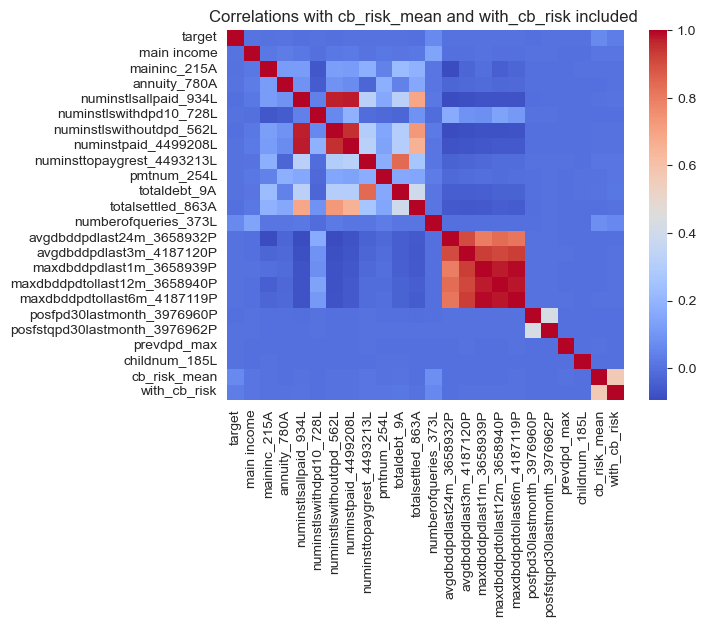

In [24]:
sns.heatmap(data.drop(columns = ['case_id','date_decision','MONTH','WEEK_NUM','riskassesment_302T','familystate_447L','income type']).corr(), annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlations with cb_risk_mean and with_cb_risk included ')
plt.show()

In [25]:
data.filter(['target','maininc_215A','main income']).corr()

,target,maininc_215A,main income
target,1.000000,0.002074,0.006057
maininc_215A,0.002074,1.000000,0.019769
main income,0.006057,0.019769,1.000000


In [26]:
print('---Correlation between default and number of instalments without dpd---')
print('overall population:',data.filter(['target','maininc_215A']).corr()['maininc_215A']['target'])
print()
for i in data['income type'].value_counts().index.values:
    print(i,': ',data[data['income type'] == i].filter(['target','maininc_215A']).corr()['maininc_215A']['target'])

---Correlation between default and number of instalments without dpd---
overall population: 0.002074390447242314

PRIVATE_SECTOR_EMPLOYEE :  0.003080657165728051
SALARIED_GOVT :  0.0027713280793630985
RETIRED_PENSIONER :  0.000375624199174575
EMPLOYED :  0.0027879868708997747
SELFEMPLOYED :  0.0062254173299458836
OTHER :  -0.004146089151398521
HANDICAPPED_2 :  -0.018115004627681525
HANDICAPPED_3 :  -0.010727403790749195
HANDICAPPED :  nan


In [271]:
data

,case_id,date_decision,MONTH,WEEK_NUM,target,main income,annuity_780A,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithoutdpd_562L,...,posfstqpd30lastmonth_3976962P,prevdpd_max,familystate_447L,childnum_185L,income type,cb_risk_mean,with_cb_risk,in_gov_self_hand2,maininc_215A,test
0,0,2019-01-03,201901,0,0,10800.0,1917.6000,NaN,NaN,NaN,...,NaN,0.0,MARRIED,0.0,SALARIED_GOVT,0.0,0,1,NaN,1
1,1,2019-01-03,201901,0,0,10000.0,3134.0000,NaN,NaN,NaN,...,NaN,0.0,DIVORCED,0.0,SALARIED_GOVT,0.0,0,1,NaN,0
2,2,2019-01-04,201901,0,0,14000.0,4937.0000,NaN,NaN,NaN,...,NaN,0.0,MARRIED,0.0,EMPLOYED,0.0,0,0,NaN,0
3,3,2019-01-03,201901,0,0,10000.0,4643.6000,NaN,NaN,NaN,...,NaN,0.0,MARRIED,0.0,EMPLOYED,0.0,0,0,NaN,0
4,4,2019-01-04,201901,0,1,24000.0,3390.2000,NaN,NaN,NaN,...,NaN,0.0,MARRIED,0.0,EMPLOYED,0.0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,40000.0,3675.4001,112.0,0.0,117.0,...,0.0,0.0,NaN,0.0,RETIRED_PENSIONER,0.0,0,0,36000.0,0
1526655,2703451,2020-10-05,202010,91,0,36800.0,7088.6000,73.0,0.0,76.0,...,0.0,0.0,NaN,0.0,RETIRED_PENSIONER,0.0,0,0,NaN,0
1526656,2703452,2020-10-05,202010,91,0,30000.0,7788.8003,6.0,0.0,8.0,...,0.0,0.0,NaN,0.0,PRIVATE_SECTOR_EMPLOYEE,0.0,0,0,24000.0,0
1526657,2703453,2020-10-05,202010,91,0,30000.0,1195.4000,89.0,7.0,109.0,...,0.0,0.0,NaN,0.0,RETIRED_PENSIONER,0.0,0,0,NaN,0


We engineer the following features for dpd behaviors:

In [27]:
def weighted_avgdbddpd(x,y):
# Defining weights for avgdbddpd [avgdbddpdlast24m_3658932P, avgdbddpdlast3m_4187120P]
    weights_avgdbddpd = {'avgdbddpdlast24m_3658932P': 0.8,  # Higher weight for longer-term behavior
               'avgdbddpdlast3m_4187120P': 0.2    # Lower weight for more recent behavior
              }    
    if pd.isna(x):
        if pd.isna(y):
            return np.nan
        else:
            return y
    else:
        if pd.isna(y):
            return x
        else:
            return x*weights_avgdbddpd['avgdbddpdlast24m_3658932P']+y*weights_avgdbddpd['avgdbddpdlast3m_4187120P']

In [28]:
data['weighted_avg_dpd']=data.apply(lambda x: weighted_avgdbddpd(x['avgdbddpdlast24m_3658932P'],x['avgdbddpdlast3m_4187120P']), axis=1)

In [29]:
def weighted_maxdbddpd(x,y,z):
# Defining weights for maxdbddpd [maxdbddpdtollast12m_3658940P, maxdbddpdtollast6m_4187119P,maxdbddpdlast1m_3658939P]
    weights_maxdbddpd = {
    'maxdbddpdtollast12m_3658940P': 0.997,  # Higher weight for longer-term behavior
    'maxdbddpdtollast6m_4187119P': 0.002,    # Lower weight for more recent behavior
    'maxdbddpdlast1m_3658939P': 0.001    # Lower weight for more recent behavior
}
    n_x = pd.isna(x)
    n_y = pd.isna(y)
    n_z = pd.isna(z)
    if n_x & n_y & n_z:
        return np.nan
    else:
        if n_x == 1:
            x = 0
        else:
            if n_y == 1:
                y = 0
            else:
                if n_z == 1:
                    z = 0
        
        return (x*weights_maxdbddpd['maxdbddpdtollast12m_3658940P']+y*weights_maxdbddpd['maxdbddpdtollast6m_4187119P']+z*weights_maxdbddpd['maxdbddpdlast1m_3658939P'])/((1-n_x)*weights_maxdbddpd['maxdbddpdtollast12m_3658940P']+(1-n_y)*weights_maxdbddpd['maxdbddpdtollast6m_4187119P']+(1-n_z)*weights_maxdbddpd['maxdbddpdlast1m_3658939P'])   

In [31]:
data['weighted_maxdbddpdlastxm']=data.apply(lambda x: weighted_maxdbddpd(x['maxdbddpdtollast12m_3658940P'],x['maxdbddpdtollast6m_4187119P'],x['maxdbddpdlast1m_3658939P']), axis=1)

In [32]:
def weighted_posfpd(x,y):
# Defining weights for posfpd [posfpd30lastmonth_3976960P, posfstqpd30lastmonth_3976962P]
    weights_posfpd = {'posfpd30lastmonth_3976960P': 0.2,  # Lower weight for longer-term behavior
               'posfstqpd30lastmonth_3976962P': 0.8    # Higher weight for more recent behavior
              }    
    if pd.isna(x):
        if pd.isna(y):
            return np.nan
        else:
            return y
    else:
        if pd.isna(y):
            return x
        else:
            return x*weights_posfpd['posfpd30lastmonth_3976960P']+y*weights_posfpd['posfstqpd30lastmonth_3976962P']

In [33]:
data['weighted_posfpd']=data.apply(lambda x: weighted_posfpd(x['posfpd30lastmonth_3976960P'],x['posfstqpd30lastmonth_3976962P']), axis=1)

In [35]:
data.filter(['target','weighted_posfpd','weighted_maxdbddpdlastxm','weighted_avg_dpd']).corr()

,target,weighted_posfpd,weighted_maxdbddpdlastxm,weighted_avg_dpd
target,1.000000,0.000235,0.001456,0.000965
weighted_posfpd,0.000235,1.000000,0.003983,0.002825
weighted_maxdbddpdlastxm,0.001456,0.003983,1.000000,0.853691
weighted_avg_dpd,0.000965,0.002825,0.853691,1.000000


In [37]:
len(data[data.target == 1])/len(data)

0.03143727577671242

The correlations are improved a little bit.